<h1><center>IAGA Summer School 2019</center></h1>

In [1]:
# Import notebook dependencies

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')
from src import sha_lib as sha, mag_lib as mag

IGRF12_FILE = os.path.abspath('../data/external/igrf12coeffs.txt')

# 1. Spherical harmonics and representing the geomagnetic field

The north (X), east (Y) and vertical (Z) (downwards) components of the geomagnetic field at colatitude $\theta$, longitude $\phi$ and radial distance $r$ (in geocentric coordinates with reference radius $a$=6371.2 km for the IGRF) are written as follows:

$$\begin{align}
&X= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2}\left[ g_n^oX_n^o+\sum_{m=1}^N\left( g_n^m\cos m\phi+h_n^m\sin m\phi \right)X_n^m\right]\\[6pt]
&Y= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2} \sum_{m=1}^N \left(g_n^m\sin m\phi-h_n^m\cos m\phi \right)Y_n^m \\[6pt]
&Z= \sum_{n=1}^N\left(\frac{a}{r}\right)^{n+2} \left[g_n^oZ_n^o+\sum_{m=1}^N\left( g_n^m\cos m\phi+h_n^m\sin m\phi \right)Z_n^m\right]\\[6pt]
\text{with}&\\[6pt]
&X_n^m=\frac{dP_n^n}{d\theta}\\[6pt]
&Y_n^m=\frac{m}{\sin \theta}P_n^m \kern{10ex} \text{(Except at the poles where $Y_n^m=X_n^m\cos \theta$.)}\\[6pt]
&Z_n^m=-(n+1)P_n^m
\end{align}$$


where the ($g_n^m, h_n^m$) are the Gauss coefficients for a particular model (such as the IGRF).

The Associated Legendre polynomials of degree $l$ and order $m$ are defined, in Schmidt semi-normalised form by,

$$P^l_m= \frac{1}{2^1l!}\left[ \frac{(2-\delta_{om})(l-m)!\left(1-x^2\right)^m}{n+m)!} \right]^{1/2}\frac{d^{l+m}}{dx^{l+m}}\left(1-x^2\right)^{l}$$


and the $X_n^m$, $Y_n^m$ and $Z_n^n$ may be calculated using the following recurrence relations (e.g. Malin and Barraclough, 1981),

$$\begin{align}
P_n^n&=\left(1-\frac{1}{2n}\right)^{1/2}\sin \theta \thinspace P_{n-1}^{n-1} \\[6pt]
P_n^m&=\left[\left(2n-1\right) \cos \theta \thinspace P_{n-1}^m-\left[ \left(n-1\right)^2-m^2\right]^{1/2}P_{n-2}^m\right]\left(n^2-m^2\right)^{-1/2}\\[6pt]
X_n^n&=\left(1-\frac{1}{2n}\right)^{1/2}\left( \sin \theta \thinspace X_{n-1}^{n-1}+ \cos \theta \thinspace P_{n-1}^{n-1} \right)\\[6pt]
X_n^m&=\left[\left(2n-1\right) \cos \theta \thinspace X_{n-1}^m- \sin \theta \thinspace P_{n-1}^m\right] - \left[ \left(n-1\right)^2-m^2\right]^{1/2}X_{n-2}^m\left(n^2-m^2\right)^{-1/2}
\end{align}$$

# 2. Plotting functions P(n,m) and X(n,m)
The $P_n^m(\theta)$ and $X_n^m(\theta)$ are building blocks for computing geomagnetic field models given a spherical harmonic model. It's instructive to visualise these functions and below you can experiment by setting different values of spherical harmonic degree ($n$) and order ($m \le n$). Note how the choice of $n$ and $m$ affects the number of zeroes of the functions. 

(The functions are plotted on a semi-circle representing the surface of the Earth, with the inner core added for cosmetic purposes only! Again, purely for cosmetic purposes, the functions are scaled to fit within +/-10% of the Earth's surface.)

### >> Set the degree and order for the plot

In [2]:
degree = 13
order  = 5

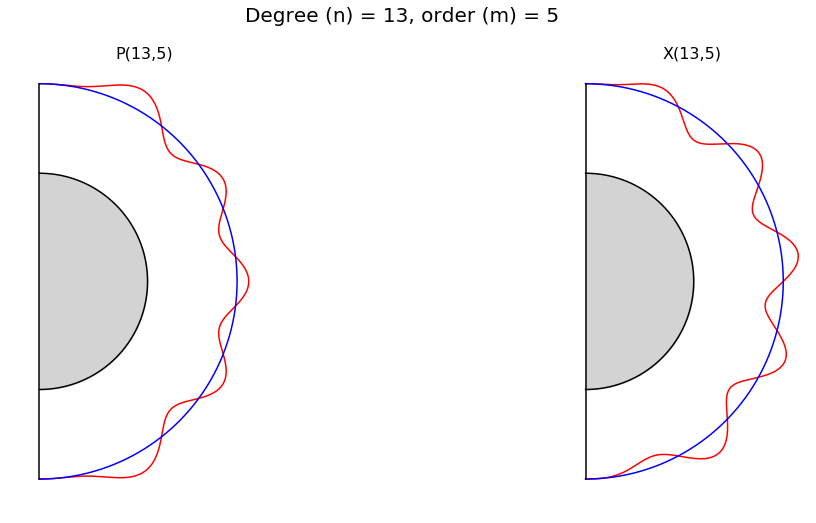

In [3]:
# Calculate Pnm and Xmn values every 0.5 degrees
colat   = np.linspace(0,180,361)
pnmvals = np.zeros(len(colat))
xnmvals = np.zeros(len(colat))

idx     = sha.pnmindex(degree,order)
for i, cl in enumerate(colat):
    p,x = sha.pxyznm_calc(degree, cl)[0:2]
    pnmvals[i] = p[idx]
    xnmvals[i] = x[idx]
    
theta   = np.deg2rad(colat)
ct      = np.cos(theta)
st      = np.sin(theta)

# Numbers mimicking the Earth's surface and outer core radii
e_rad   = 6.371
c_rad   = 3.485

# Scale values to fit within 10% of "Earth's surface". Firstly the P(n,m),
shell   = 0.1*e_rad
pmax    = np.abs(pnmvals).max()
pnmvals = pnmvals*shell/pmax + e_rad
xp      = pnmvals*st
yp      = pnmvals*ct

# and now the X(n,m)
xmax    = np.abs(xnmvals).max()
xnmvals = xnmvals*shell/xmax + e_rad
xx      = xnmvals*st
yx      = xnmvals*ct

# Values to draw the Earth's and outer core surfaces as semi-circles
e_xvals = e_rad*st
e_yvals = e_rad*ct
c_xvals = e_xvals*c_rad/e_rad
c_yvals = e_yvals*c_rad/e_rad

# Earth-like background framework for plots
def eplot(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.plot(e_xvals,e_yvals, color='blue')
    ax.plot(c_xvals,c_yvals, color='black')
    ax.fill_between(c_xvals, c_yvals, y2=0, color='lightgrey')
    ax.plot((0, 0), (-e_rad, e_rad), color='black')

# Plot the P(n,m) and X(n,m)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Degree (n) = '+str(degree)+', order (m) = '+str(order), fontsize=20)
                    
axes[0].plot(xp,yp, color='red')
axes[0].set_title('P('+ str(degree)+',' + str(order)+')', fontsize=16)
eplot(axes[0])

axes[1].plot(xx,yx, color='red')
axes[1].set_title('X('+ str(degree)+',' + str(order)+')', fontsize=16)
eplot(axes[1])

# 3. The International Geomagnetic Reference Field
The latest version of the IGRF is IGRF12 which consists of a main-field model every five years from 1900.0 to 2015.0 and a secular variation model for 2015-2020. The main field models have spherical harmonic degree (n) and order (m) 10 up to 1995 and n=m=13 from 2000 onwards. The secular variation model has n=m=8.

The coefficients are first loaded into a pandas database: 

In [4]:
igrf12 = pd.read_csv(IGRF12_FILE, delim_whitespace=True,  header=3)
igrf12.head()  # Check the values have loaded correctly

,g/h,n,m,1900.0,1905.0,1910.0,1915.0,1920.0,1925.0,1930.0,...,1975.0,1980.0,1985.0,1990.0,1995.0,2000.0,2005.0,2010.0,2015.0,2015-20
0,g,1,0,-31543,-31464,-31354,-31212,-31060,-30926,-30805,...,-30100,-29992,-29873,-29775,-29692,-29619.4,-29554.63,-29496.57,-29442.0,10.3
1,g,1,1,-2298,-2298,-2297,-2306,-2317,-2318,-2316,...,-2013,-1956,-1905,-1848,-1784,-1728.2,-1669.05,-1586.42,-1501.0,18.1
2,h,1,1,5922,5909,5898,5875,5845,5817,5808,...,5675,5604,5500,5406,5306,5186.1,5077.99,4944.26,4797.1,-26.6
3,g,2,0,-677,-728,-769,-802,-839,-893,-951,...,-1902,-1997,-2072,-2131,-2200,-2267.7,-2337.24,-2396.06,-2445.1,-8.7
4,g,2,1,2905,2928,2948,2956,2959,2969,2980,...,3010,3027,3044,3059,3070,3068.4,3047.69,3026.34,3012.9,-3.3


## Calculating geomagnetic field values using the IGRF
The function below allows geomagnetic field values at a point defined by its colatitude, longitude and altitude, using a spherical harmonic model of maximum degree _nmax_ supplied as an array _gh_ to be calculated. The parameter _coord_ is a string specifying whether the input position is in geocentric coordinates (when _altitude_ should be the geocentric distance in km) or geodetic coordinates (when altitude is distance above mean sea level in km). 

(It's unconventional, but I've chosen to include a monpole term, set to zero, at index zero in the _gh_ array.)<br>

In [5]:
def shm_calculator(gh, nmax, altitude, colat, long, coord):
    RREF     = 6371.2 #The reference radius assumed by the IGRF
    degree   = nmax
    phi      = long

    if (coord == 'Geodetic'):
        # Geodetic to geocentric conversion using the WGS84 spheroid
        rad, theta, sd, cd = sha.gd2gc(altitude, colat)
    else:
        rad   = altitude
        theta = colat

    # Function 'rad_powers' to create an array with values of (a/r)^(n+2) for n = 0,1, 2 ..., degree
    rpow = sha.rad_powers(degree, RREF, rad)

    # Function 'csmphi' to create arrays with cos(m*phi), sin(m*phi) for m = 0, 1, 2 ..., degree
    cmphi, smphi = sha.csmphi(degree,phi)

    # Function 'gh_phi_rad' to create arrays with terms such as [g(3,2)*cos(2*phi) + h(3,2)*sin(2*phi)]*(a/r)**5 
    ghxz, ghy = sha.gh_phi_rad(gh, degree, cmphi, smphi, rpow)

    # Function 'pnm_calc' to calculate arrays of the Associated Legendre Polynomials for n (&m) = 0,1, 2 ..., degree
    pnm, xnm, ynm, znm = sha.pxyznm_calc(degree, theta)

    # Geomagnetic field components are calculated as a dot product
    X =  np.dot(ghxz, xnm)
    Y =  np.dot(ghy,  ynm)
    Z = -np.dot(ghxz, znm)

    # Convert back to geodetic (X, Y, Z) if required
    if (coord == 'Geodetic'):
        t = X
        X = X*cd + Z*sd
        Z = Z*cd - t*sd

    return((X, Y, Z))

### >> Set the input parameters here

In [6]:
location = 'Erehwon'
ctype    = 'Geodetic'  # coordinate type
altitude = 0           # in km above the spheroid if ctype = 'Geodetic', radial distance if ctype = 'Geocentric'
colat    = 35          # NB colatitude, not latitude
long     = -3          # longitude
NMAX     = 13          # Maxiimum spherical harmonic degree of the model
date     = 2015.0      # Date for the field estimates

Now calculate the IGRF geomagnetic field estimates.

In [7]:
# Calculate the gh values for the supplied date
if date == 2015.0:
    gh = igrf12['2015.0']
elif date < 2015.0:
    date_1 = (date//5)*5
    date_2 = date_1 + 5
    w1 = date-date_1
    w2 = date_2-date
    gh = np.array((w2*igrf12[str(date_1)] + w1*igrf12[str(date_2)])/(w1+w2))
elif date > 2015.0:
    gh =np.array(igrf12['2015.0'] + (date-2015.0)*igrf12['2015-20'])

gh = np.append(0., gh) # Add a zero monopole term corresponding to g(0,0)

bxyz = shm_calculator(gh, NMAX, altitude, colat, long, ctype)
dec, hoz ,inc , eff = mag.xyz2dhif(bxyz[0], bxyz[1], bxyz[2])

print('\nGeomagnetic field values at: ', location+', '+ str(date), '\n')
print('Declination (D):', '{: .1f}'.format(dec), 'degrees')
print('Inclination (I):', '{: .1f}'.format(inc), 'degrees')
print('Horizontal intensity (H):', '{: .1f}'.format(hoz), 'nT')
print('Total intensity (F)     :', '{: .1f}'.format(eff), 'nT')
print('North component (X)     :', '{: .1f}'.format(bxyz[0]), 'nT')
print('East component (Y)      :', '{: .1f}'.format(bxyz[1]), 'nT')
print('Vertical component (Z)  :', '{: .1f}'.format(bxyz[2]), 'nT')


Geomagnetic field values at:  Erehwon, 2015.0 

Declination (D): -2.5 degrees
Inclination (I): -69.5 degrees
Horizontal intensity (H):  17399.1 nT
Total intensity (F)     :  49606.9 nT
North component (X)     :  17382.1 nT
East component (Y)      : -767.4 nT
Vertical component (Z)  : -46455.5 nT


# Maps of the IGRF
Now draw maps of the IGRF (at the date selected above). The latitude range is set at -85 degrees to +85 degrees and the longitude range -180 degrees to +180 degrees and IGRF values for (X, Y, Z) are calculated on a 5 degree grid (this may take a few seconds to complete).
## >> Set the element to plot
Enter the geomagnetic element to plot below: <br>
D = declination <br>
H = horizontal intensity <br>
I = inclination <br>
X = north component <br>
Y = east component <br>
Z = vertically (downwards) component <br>
F = total intensity.)

In [8]:
el2plot = 'H'

In [9]:
def IGRF_plotter(el_name, vals, date):
    if el_name=='D':
        cvals = np.arange(-25,30,5)
    else:
        cvals = 15
    fig, ax = plt.subplots(figsize=(16, 8))
    cplt = ax.contour(longs, lats, vals, levels=cvals)
    ax.clabel(cplt, cplt.levels, inline=True, fmt='%d', fontsize=10)
    ax.set_title('IGRF: '+ el_name + ' (' + str(date) + ')', fontsize=20)
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)

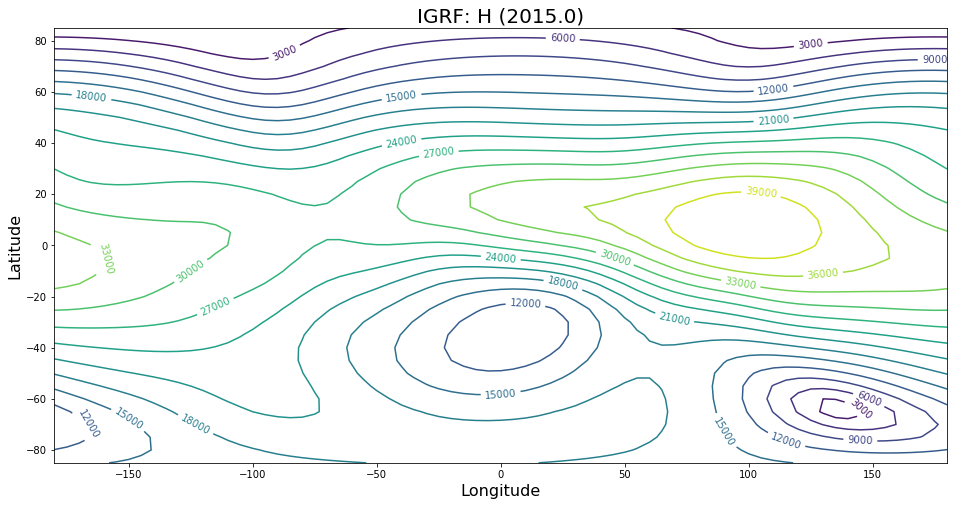

In [10]:
longs  = np.linspace(-180, 180, 73)
lats   = np.linspace(-85, 85, 35)
Bx, By, Bz = zip(*[sha.shm_calculator(gh,13,6371.2,90-lat,lon,'Geocentric') \
                 for lat in lats for lon in longs])
X = np.asarray(Bx).reshape(35,73)
Y = np.asarray(By).reshape(35,73)
Z = np.asarray(Bz).reshape(35,73)
D, H, I, F = [mag.xyz2dhif(X, Y, Z)[el] for el in range(4)]

el_dict={'X':X, 'Y':Y, 'Z':Z, 'D':D, 'H':H, 'I':I, 'F':F}
IGRF_plotter(el2plot, el_dict[el2plot], date)

### References

Malin, S. R. . and Barraclough, D., (1981). An algorithm for synthesizing the geomagnetic field, Computers & Geosciences. Pergamon, 7(4), pp. 401–405. doi: 10.1016/0098-3004(81)90082-0.